In [29]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [30]:
rho = 1
mu = 1
u_in = 0.5
D = 1
L = 10
tle = 10
v_i = -0.5
tau_0 = 10

In [31]:
geom = dde.geometry.Rectangle(xmin=[-L/2,-D/2],xmax=[L/2,D/2])

In [32]:
def upper_wall(X, on_boundary):
  on_upper_wall = np.logical_and(np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_upper_wall

def lower_wall(X, on_boundary):
  on_lower_wall = np.logical_and(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_lower_wall

def boundary_inlet(X,on_boundary):
  on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_inlet

def boundary_outlet(X,on_boundary):
  on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_outlet

In [33]:
bc_wall_u = dde.DirichletBC(geom, lambda X:v_i, upper_wall, component =0)
bc_wall_u = dde.DirichletBC(geom, lambda X:0., lower_wall, component =0)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., upper_wall, component =1)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., lower_wall, component =1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component =0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0., boundary_inlet, component =1)

bc_outlet_p = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =2)
bc_outlet_v = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component =1)

In [34]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)
    # du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    # du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    # dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    # dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    # Definições para Bingham para componentes do tensor de tensão
    tau_xy = tau_0 + mu * (du_y + dv_x)
    tau_yx = tau_0 + mu * (dv_x + du_y)
    tau_xx = tau_0 + mu * (du_x + du_x)
    tau_yy = tau_0 + mu * (dv_y + du_y)

    tau_diff = tau_xy - tau_0
    H_tau = tf.where(tau_diff > 0, 1.0, 0.0)
    dv_x = dde.grad.jacobian(Y, X, i=0, j=0) * H_tau
    du_y = dde.grad.jacobian(Y, X, i=0, j=1) * H_tau
    
    tau_xy = tau_0 + mu * (du_y + dv_x)
    tau_yx = tau_0 + mu * (dv_x + du_y)
    tau_xx = tau_0 + mu * (du_x + du_x)
    tau_yy = tau_0 + mu * (dv_y + du_y)

    # Derivadas dos tensores de tensão
    dtau_xy_y = dde.grad.jacobian(tau_xy, X, i=0, j=1)
    dtau_yx_x = dde.grad.jacobian(tau_yx, X, i=0, j=0)
    dtau_xx_x = dde.grad.jacobian(tau_xx, X, i=0, j=0)
    dtau_yy_y = dde.grad.jacobian(tau_yy, X, i=0, j=1)

    # Equações de Navier-Stokes modificadas para incluir todos os tensores de tensão
    pde_u = rho * (Y[:,0:1] * du_x + Y[:,1:2] * du_y) + dp_x - dtau_yx_x - dtau_xx_x
    pde_v = rho * (Y[:,0:1] * dv_x + Y[:,1:2] * dv_y) + dp_y - dtau_xy_y - dtau_yy_y
    pde_cont = du_x + dv_y  # Equação de continuidade

    return [pde_u, pde_v, pde_cont]


In [35]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u,bc_wall_v,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                    num_domain = 10000,
                    num_boundary = 5000,
                    num_test = 10000)

<function matplotlib.pyplot.show(close=None, block=None)>

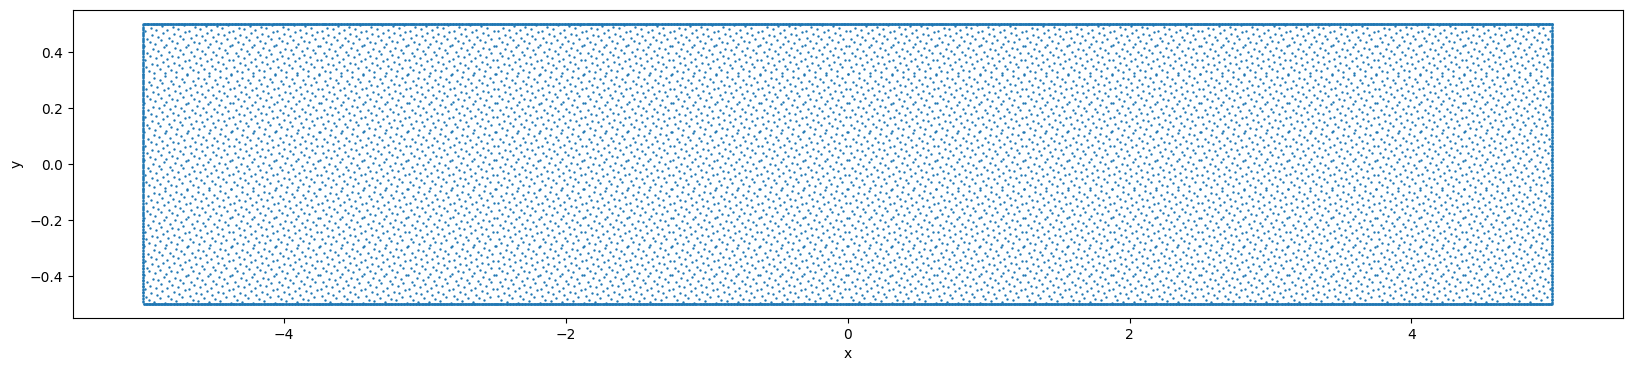

In [36]:
plt.figure(figsize=(20,4))
plt.scatter(data.train_x_all[:,0],data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show

In [37]:
net = dde.maps.FNN([2]+[64]*5+[3], "tanh","Glorot uniform")

In [38]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.067116 s



c:\Users\Pablo\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-4PBOT-FI-py3.10\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.956739 s



In [39]:
losshistory,train_state = model.train(epochs = 10000)

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.02e-02, 6.66e-03, 1.94e-02, 3.24e-03, 6.82e-02, 1.69e-01, 1.44e-01, 2.86e-02, 1.44e-01]    [1.13e-02, 6.38e-03, 2.01e-02, 3.24e-03, 6.82e-02, 1.69e-01, 1.44e-01, 2.86e-02, 1.44e-01]    []  
1000      [3.02e-04, 1.48e-04, 1.19e-03, 6.66e-03, 8.87e-05, 3.77e-03, 9.54e-04, 1.35e-05, 1.25e-05]    [1.93e-04, 9.99e-05, 9.29e-04, 6.66e-03, 8.87e-05, 3.77e-03, 9.54e-04, 1.35e-05, 1.25e-05]    []  
2000      [5.86e-04, 3.99e-04, 1.42e-03, 5.67e-03, 3.51e-05, 2.48e-03, 6.56e-04, 4.86e-06, 7.58e-07]    [3.44e-04, 4.04e-04, 9.28e-04, 5.67e-03, 3.51e-05, 2.48e-03, 6.56e-04, 4.86e-06, 7.58e-07]    []  
3000      [4.97e-04, 3.76e-04, 1.76e-03, 5.84e-03, 4.58e-05, 2.31e-03, 4.75e-04, 2.56e-06, 8.10e-05]    [4.09e-04, 3.98e-04, 1.16e-03, 5.84e-03, 4.58e-05, 2.31e-0

In [40]:
dde.optimizers.config.set_LBFGS_options(maxiter = 1000)
model.compile("L-BFGS")
losshistory,train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

Compiling model...
'compile' took 2.397707 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [4.59e-04, 3.70e-04, 1.38e-03, 5.80e-03, 3.95e-05, 2.18e-03, 4.89e-04, 9.56e-06, 7.73e-06]    [4.05e-04, 4.30e-04, 7.48e-04, 5.80e-03, 3.95e-05, 2.18e-03, 4.89e-04, 9.56e-06, 7.73e-06]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.010635
  Number of iterations: 13
  Number of functions evaluations: 90
10076     [4.74e-04, 3.49e-04, 1.41e-03, 5.90e-03, 2.28e-05, 2.07e-03, 4.06e-04, 2.69e-06, 2.77e-07]    [4.04e-04, 4.16e-04, 7.63e-04, 5.90e-03, 2.28e-05, 2.07e-03, 4.06e-04, 2.69e-06, 2.77e-07]    []  

Best model at step 8000:
  train loss: 1.03e-02
  test loss: 9.41e-03
  test metric: []

'train' took 59.854287

In [41]:
samples= geom.random_points(500000)
result = model.predict(samples)

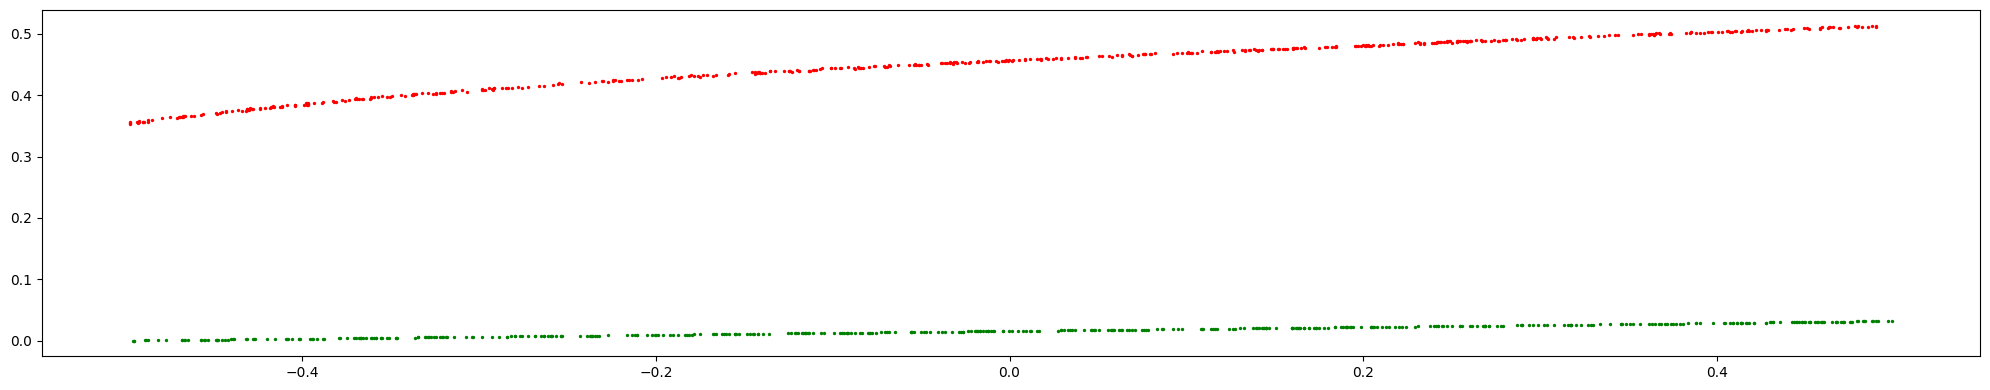

In [46]:
color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
# for idx in range(3):
plt.figure(figsize=(20,4))
mask = np.where((samples[:,0] > 4.9) & (samples[:,0] < 4.91))
plt.scatter(samples[mask,1], result[mask,0], c='green',s=2)
mask = np.where((samples[:,0] < -4.9) & (samples[:,0] > -4.91))
plt.scatter(samples[mask,1], result[mask,0], c='red',s=2)
plt.tight_layout()
plt.show()

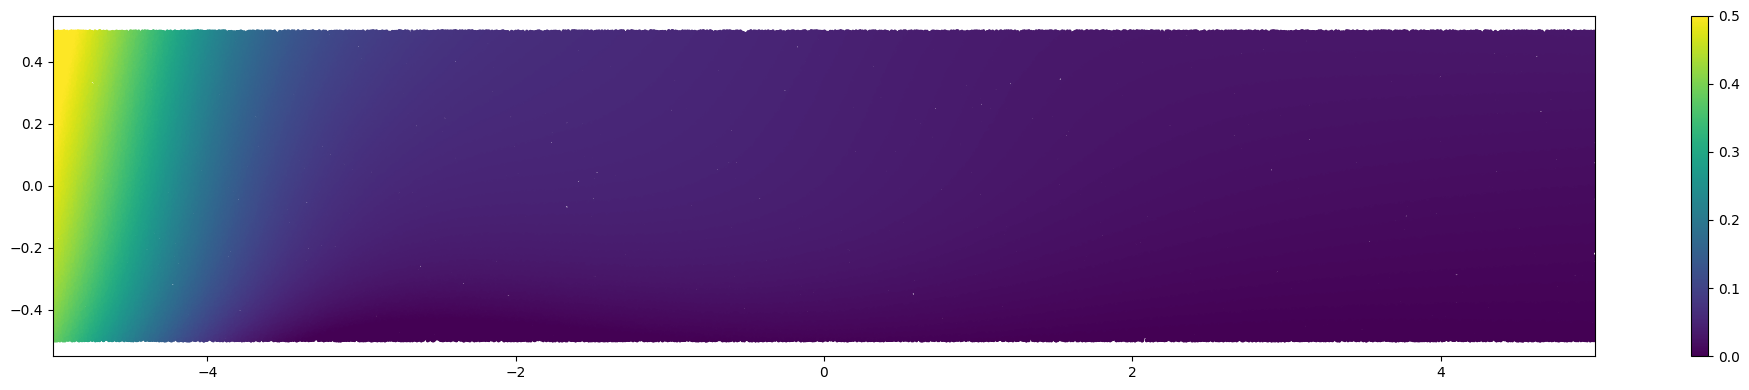

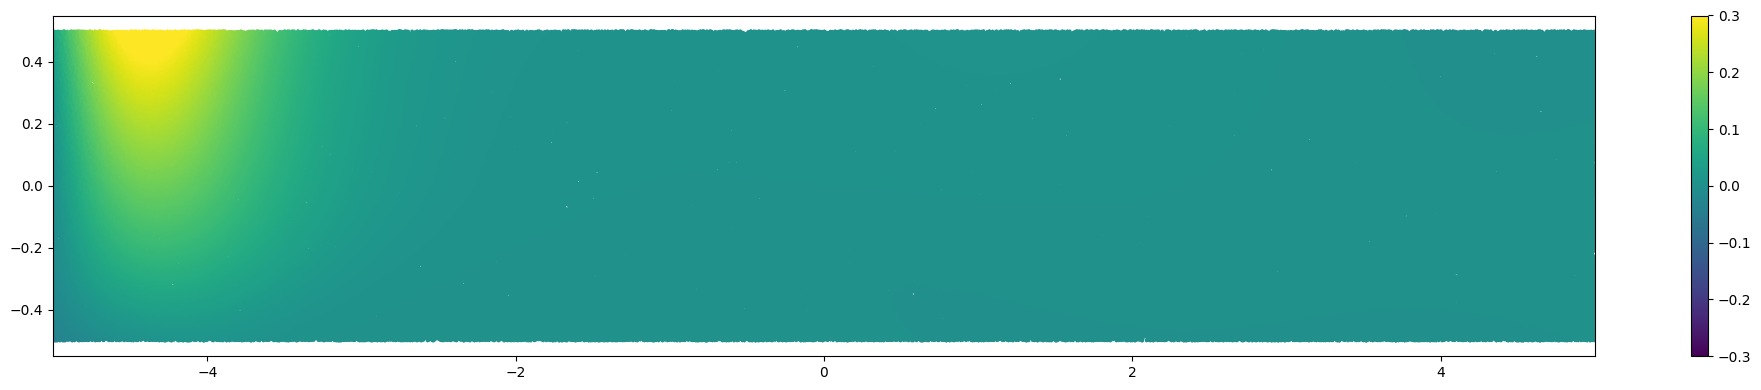

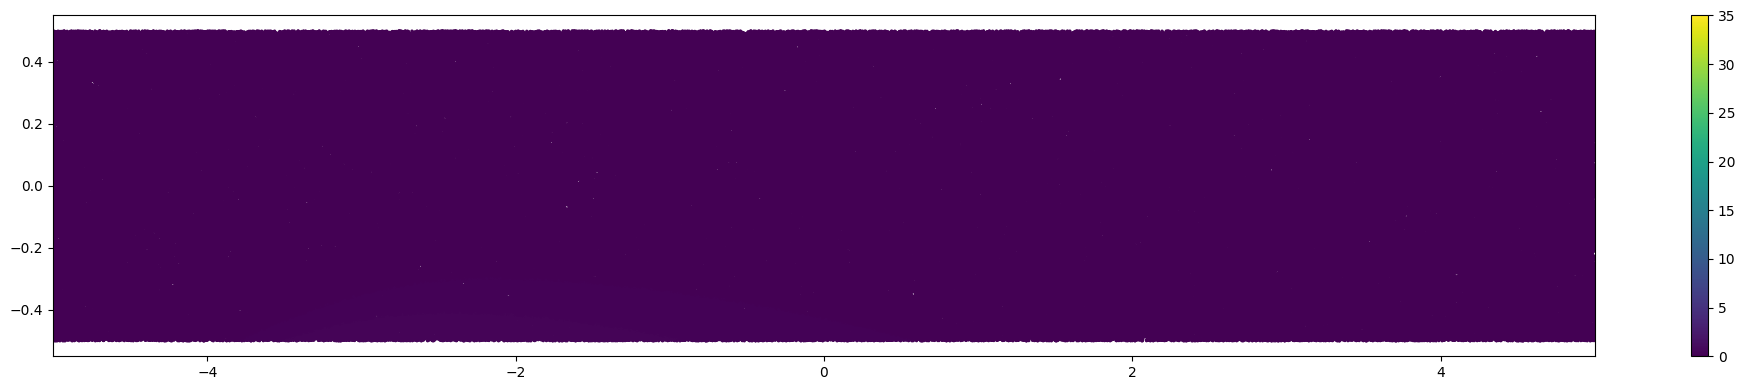

In [44]:
color_legend=[[0,0.5],[-0.3,0.3],[0,35]]
for idx in range(3):
  plt.figure(figsize=(20,4))
  plt.scatter(samples[:,0], samples[:,1], c=result[:,idx], cmap='viridis',s=2)
  plt.colorbar()
  plt.clim(color_legend[idx])
  plt.xlim((0-D/2,D-D/2))
  plt.xlim((0-L/2,L-L/2))
  plt.tight_layout()
  plt.show()